# Check the Python version being used

In [1]:
!python --version

Python 3.7.6


# Check that the available gpu is being utilized

In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available")
print(len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available
1


# Start of second method of lstm time series forecasting

In [4]:
from pandas import read_csv

df = read_csv('Time_Series_For_Clustering_El_Paso_Final.csv')

# get each separate time series as an individual list and append each of these lists to a master list

In [5]:
import re
import pandas as pd

non_decimal = re.compile(r'[^\d.]+')

list_of_training_df = []
list_of_row_components = []

for i in range(1, 524):
    
    current_row = df.iloc[i]
    
    bridge_id = current_row.iloc[0]
    
    current_row = current_row.iloc[1:]
    
    for j, row in current_row.iteritems():
        
        current_row_components = row.split(', ')
        current_row_components_replaced = []

        for idx, component in enumerate(current_row_components):

            result = non_decimal.sub('', current_row_components[idx])
            current_row_components_replaced.append(float(result))

        list_of_row_components.append(current_row_components_replaced)

# Ensure each element in the list of lists is a float

In [6]:
for idx, element in enumerate(list_of_row_components):
    for i in range(1, len(element)):
        list_of_row_components[idx][i] = float(list_of_row_components[idx][i])

# View one time series

In [7]:
for i in range(22):
    print(list_of_row_components[i])

[36.0, 97.0, 428.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.3, 97.0, 955.0, 1949.0, 2.0, 11.0, 7.0]
[36.3, 96.9, 955.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 97.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 522.0, 1949.0, 2.0, 9.7, 7.3]


# Get length of list of lists

In [8]:
len(list_of_row_components)

11506

# Swap last entry with second entry in time series to make the output predictor variable Sufficiency Rating

In [9]:
for idx, component in enumerate(list_of_row_components):
    temp = component[6]
    list_of_row_components[idx][6] = list_of_row_components[idx][1]
    list_of_row_components[idx][1] = temp

# Convert format of list to have a single time series for each index

In [10]:
import numpy as np

list_of_examples = []
temp_list = []

max_num = 22
iter = 0;

for row_component in list_of_row_components:
    if iter == max_num:
        list_of_examples.append(np.array(temp_list))
        temp_list = []
        iter = 0
        
    temp_list.append(np.array(row_component))
    iter += 1

list_of_examples = np.array(list_of_examples)

# Make the very last time step of each time series just a single value (Sufficiency Rating) for the model to predict on

In [11]:
for idx, example in enumerate(list_of_examples):
    list_of_examples[idx][21] = [list_of_examples[idx][21][6]]

# Perform train test split for dataset

In [12]:
from sklearn.model_selection import train_test_split

n_train_periods = 300
train = list_of_examples[:n_train_periods, :]
test = list_of_examples[n_train_periods:, :]

# split into input and outputs
train_X, train_y = train[:, :-1, 1:], train[:, -1, 0]
test_X, test_y = test[:, :-1, 1:], test[:, -1, 0]


In [13]:
print("Shape of train_X: " + str(train_X.shape))
print("Shape of train_y: " + str(train_y.shape))
print("Shape of test_X: " + str(test_X.shape))
print("Shape of test_y: " + str(test_y.shape))

Shape of train_X: (300, 21, 6)
Shape of train_y: (300,)
Shape of test_X: (222, 21, 6)
Shape of test_y: (222,)


# Build cnn model

In [14]:
cnn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, input_shape=(train_X.shape[1],train_X.shape[2])),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=1)
])

# Compile model

In [15]:
cnn_model.compile(loss='mae', optimizer='adam')

# Train model

In [16]:
history = cnn_model.fit(train_X, train_y, epochs=2000, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/2000
10/10 - 0s - loss: 416.7484 - val_loss: 815.7726
Epoch 2/2000
10/10 - 0s - loss: 272.6307 - val_loss: 479.9409
Epoch 3/2000
10/10 - 0s - loss: 241.2914 - val_loss: 603.3601
Epoch 4/2000
10/10 - 0s - loss: 236.0196 - val_loss: 423.6980
Epoch 5/2000
10/10 - 0s - loss: 185.1173 - val_loss: 368.1104
Epoch 6/2000
10/10 - 0s - loss: 234.3577 - val_loss: 356.1903
Epoch 7/2000
10/10 - 0s - loss: 164.0596 - val_loss: 299.7514
Epoch 8/2000
10/10 - 0s - loss: 185.8985 - val_loss: 301.3595
Epoch 9/2000
10/10 - 0s - loss: 166.8116 - val_loss: 377.9064
Epoch 10/2000
10/10 - 0s - loss: 181.7920 - val_loss: 400.3602
Epoch 11/2000
10/10 - 0s - loss: 196.4443 - val_loss: 372.2409
Epoch 12/2000
10/10 - 0s - loss: 184.0481 - val_loss: 415.4884
Epoch 13/2000
10/10 - 0s - loss: 198.6722 - val_loss: 375.8378
Epoch 14/2000
10/10 - 0s - loss: 193.9977 - val_loss: 343.1208
Epoch 15/2000
10/10 - 0s - loss: 181.1949 - val_loss: 391.8637
Epoch 16/2000
10/10 - 0s - loss: 180.8441 - val_loss: 391.6026
E

Epoch 132/2000
10/10 - 0s - loss: 98.1062 - val_loss: 221.7941
Epoch 133/2000
10/10 - 0s - loss: 70.8487 - val_loss: 141.8290
Epoch 134/2000
10/10 - 0s - loss: 85.9154 - val_loss: 242.7263
Epoch 135/2000
10/10 - 0s - loss: 70.2263 - val_loss: 208.2931
Epoch 136/2000
10/10 - 0s - loss: 63.6364 - val_loss: 257.0811
Epoch 137/2000
10/10 - 0s - loss: 72.3783 - val_loss: 107.5241
Epoch 138/2000
10/10 - 0s - loss: 74.4249 - val_loss: 282.8806
Epoch 139/2000
10/10 - 0s - loss: 101.3304 - val_loss: 394.9182
Epoch 140/2000
10/10 - 0s - loss: 84.1561 - val_loss: 121.4165
Epoch 141/2000
10/10 - 0s - loss: 106.0485 - val_loss: 125.5976
Epoch 142/2000
10/10 - 0s - loss: 79.4017 - val_loss: 142.6167
Epoch 143/2000
10/10 - 0s - loss: 54.9791 - val_loss: 168.0160
Epoch 144/2000
10/10 - 0s - loss: 104.9327 - val_loss: 226.6480
Epoch 145/2000
10/10 - 0s - loss: 74.1078 - val_loss: 108.4796
Epoch 146/2000
10/10 - 0s - loss: 64.6294 - val_loss: 317.6041
Epoch 147/2000
10/10 - 0s - loss: 114.3621 - val_los

Epoch 263/2000
10/10 - 0s - loss: 85.0305 - val_loss: 132.2248
Epoch 264/2000
10/10 - 0s - loss: 90.0901 - val_loss: 193.8062
Epoch 265/2000
10/10 - 0s - loss: 89.2247 - val_loss: 137.5420
Epoch 266/2000
10/10 - 0s - loss: 89.3424 - val_loss: 156.6777
Epoch 267/2000
10/10 - 0s - loss: 80.1094 - val_loss: 125.3366
Epoch 268/2000
10/10 - 0s - loss: 75.7761 - val_loss: 162.3362
Epoch 269/2000
10/10 - 0s - loss: 64.9369 - val_loss: 115.5203
Epoch 270/2000
10/10 - 0s - loss: 41.5317 - val_loss: 126.3420
Epoch 271/2000
10/10 - 0s - loss: 55.7329 - val_loss: 151.0205
Epoch 272/2000
10/10 - 0s - loss: 41.8595 - val_loss: 149.0755
Epoch 273/2000
10/10 - 0s - loss: 45.5449 - val_loss: 109.9888
Epoch 274/2000
10/10 - 0s - loss: 44.0830 - val_loss: 166.4351
Epoch 275/2000
10/10 - 0s - loss: 53.2815 - val_loss: 241.5776
Epoch 276/2000
10/10 - 0s - loss: 60.6827 - val_loss: 85.6188
Epoch 277/2000
10/10 - 0s - loss: 60.9808 - val_loss: 122.8682
Epoch 278/2000
10/10 - 0s - loss: 55.7922 - val_loss: 12

Epoch 394/2000
10/10 - 0s - loss: 32.4247 - val_loss: 56.8175
Epoch 395/2000
10/10 - 0s - loss: 35.5546 - val_loss: 141.9087
Epoch 396/2000
10/10 - 0s - loss: 45.6553 - val_loss: 197.6340
Epoch 397/2000
10/10 - 0s - loss: 39.5120 - val_loss: 63.7665
Epoch 398/2000
10/10 - 0s - loss: 35.4737 - val_loss: 43.8964
Epoch 399/2000
10/10 - 0s - loss: 17.6010 - val_loss: 125.5058
Epoch 400/2000
10/10 - 0s - loss: 42.8844 - val_loss: 145.2569
Epoch 401/2000
10/10 - 0s - loss: 49.1149 - val_loss: 66.5561
Epoch 402/2000
10/10 - 0s - loss: 43.4898 - val_loss: 40.6834
Epoch 403/2000
10/10 - 0s - loss: 22.5620 - val_loss: 98.2406
Epoch 404/2000
10/10 - 0s - loss: 46.7873 - val_loss: 97.4092
Epoch 405/2000
10/10 - 0s - loss: 46.3541 - val_loss: 68.4961
Epoch 406/2000
10/10 - 0s - loss: 20.5200 - val_loss: 50.5933
Epoch 407/2000
10/10 - 0s - loss: 37.3480 - val_loss: 195.4943
Epoch 408/2000
10/10 - 0s - loss: 49.4302 - val_loss: 40.2190
Epoch 409/2000
10/10 - 0s - loss: 31.5661 - val_loss: 139.7183
Ep

Epoch 526/2000
10/10 - 0s - loss: 40.0873 - val_loss: 91.2848
Epoch 527/2000
10/10 - 0s - loss: 36.4338 - val_loss: 62.0765
Epoch 528/2000
10/10 - 0s - loss: 40.6536 - val_loss: 79.7857
Epoch 529/2000
10/10 - 0s - loss: 34.2110 - val_loss: 66.7533
Epoch 530/2000
10/10 - 0s - loss: 38.4506 - val_loss: 99.1229
Epoch 531/2000
10/10 - 0s - loss: 37.5896 - val_loss: 61.1688
Epoch 532/2000
10/10 - 0s - loss: 40.7895 - val_loss: 74.6085
Epoch 533/2000
10/10 - 0s - loss: 32.9782 - val_loss: 68.1568
Epoch 534/2000
10/10 - 0s - loss: 38.4478 - val_loss: 95.5941
Epoch 535/2000
10/10 - 0s - loss: 36.7803 - val_loss: 57.5913
Epoch 536/2000
10/10 - 0s - loss: 39.1734 - val_loss: 75.6722
Epoch 537/2000
10/10 - 0s - loss: 32.9790 - val_loss: 63.7105
Epoch 538/2000
10/10 - 0s - loss: 36.9530 - val_loss: 98.9367
Epoch 539/2000
10/10 - 0s - loss: 37.3942 - val_loss: 54.4069
Epoch 540/2000
10/10 - 0s - loss: 38.5121 - val_loss: 75.6359
Epoch 541/2000
10/10 - 0s - loss: 32.4777 - val_loss: 65.8833
Epoch 54

10/10 - 0s - loss: 27.0920 - val_loss: 79.5412
Epoch 659/2000
10/10 - 0s - loss: 26.9330 - val_loss: 60.3282
Epoch 660/2000
10/10 - 0s - loss: 25.6335 - val_loss: 33.1797
Epoch 661/2000
10/10 - 0s - loss: 15.5352 - val_loss: 42.0738
Epoch 662/2000
10/10 - 0s - loss: 22.8840 - val_loss: 29.1901
Epoch 663/2000
10/10 - 0s - loss: 20.9909 - val_loss: 26.2649
Epoch 664/2000
10/10 - 0s - loss: 24.7125 - val_loss: 52.2060
Epoch 665/2000
10/10 - 0s - loss: 22.6154 - val_loss: 37.4276
Epoch 666/2000
10/10 - 0s - loss: 27.8940 - val_loss: 54.7566
Epoch 667/2000
10/10 - 0s - loss: 22.2056 - val_loss: 21.4957
Epoch 668/2000
10/10 - 0s - loss: 13.2644 - val_loss: 21.4053
Epoch 669/2000
10/10 - 0s - loss: 17.5637 - val_loss: 105.3857
Epoch 670/2000
10/10 - 0s - loss: 27.0040 - val_loss: 75.5361
Epoch 671/2000
10/10 - 0s - loss: 27.2173 - val_loss: 92.6666
Epoch 672/2000
10/10 - 0s - loss: 20.2983 - val_loss: 36.2155
Epoch 673/2000
10/10 - 0s - loss: 26.9891 - val_loss: 47.9695
Epoch 674/2000
10/10 -

Epoch 790/2000
10/10 - 0s - loss: 24.1417 - val_loss: 107.6730
Epoch 791/2000
10/10 - 0s - loss: 25.2315 - val_loss: 136.0823
Epoch 792/2000
10/10 - 0s - loss: 27.8106 - val_loss: 80.5830
Epoch 793/2000
10/10 - 0s - loss: 20.4723 - val_loss: 103.2567
Epoch 794/2000
10/10 - 0s - loss: 23.9398 - val_loss: 107.5768
Epoch 795/2000
10/10 - 0s - loss: 25.0029 - val_loss: 131.4837
Epoch 796/2000
10/10 - 0s - loss: 27.3679 - val_loss: 82.5608
Epoch 797/2000
10/10 - 0s - loss: 20.2419 - val_loss: 98.1809
Epoch 798/2000
10/10 - 0s - loss: 23.4290 - val_loss: 109.6593
Epoch 799/2000
10/10 - 0s - loss: 25.3342 - val_loss: 130.8303
Epoch 800/2000
10/10 - 0s - loss: 27.2212 - val_loss: 77.4295
Epoch 801/2000
10/10 - 0s - loss: 19.4557 - val_loss: 96.0570
Epoch 802/2000
10/10 - 0s - loss: 23.1918 - val_loss: 109.9987
Epoch 803/2000
10/10 - 0s - loss: 25.0643 - val_loss: 126.0370
Epoch 804/2000
10/10 - 0s - loss: 26.6388 - val_loss: 76.0426
Epoch 805/2000
10/10 - 0s - loss: 19.0248 - val_loss: 94.0378

Epoch 922/2000
10/10 - 0s - loss: 17.8973 - val_loss: 70.7165
Epoch 923/2000
10/10 - 0s - loss: 15.2060 - val_loss: 69.6098
Epoch 924/2000
10/10 - 0s - loss: 19.0058 - val_loss: 67.4338
Epoch 925/2000
10/10 - 0s - loss: 14.4501 - val_loss: 64.6977
Epoch 926/2000
10/10 - 0s - loss: 17.5893 - val_loss: 65.4190
Epoch 927/2000
10/10 - 0s - loss: 14.4144 - val_loss: 55.5736
Epoch 928/2000
10/10 - 0s - loss: 16.9615 - val_loss: 69.7264
Epoch 929/2000
10/10 - 0s - loss: 15.6496 - val_loss: 68.6271
Epoch 930/2000
10/10 - 0s - loss: 18.4023 - val_loss: 62.5912
Epoch 931/2000
10/10 - 0s - loss: 14.4371 - val_loss: 60.1448
Epoch 932/2000
10/10 - 0s - loss: 17.5335 - val_loss: 64.1383
Epoch 933/2000
10/10 - 0s - loss: 13.9151 - val_loss: 53.6226
Epoch 934/2000
10/10 - 0s - loss: 16.0747 - val_loss: 67.0950
Epoch 935/2000
10/10 - 0s - loss: 15.0072 - val_loss: 70.1307
Epoch 936/2000
10/10 - 0s - loss: 19.1096 - val_loss: 57.6153
Epoch 937/2000
10/10 - 0s - loss: 12.2841 - val_loss: 50.2254
Epoch 93

Epoch 1054/2000
10/10 - 0s - loss: 10.6872 - val_loss: 16.6929
Epoch 1055/2000
10/10 - 0s - loss: 8.6478 - val_loss: 11.1978
Epoch 1056/2000
10/10 - 0s - loss: 10.4831 - val_loss: 21.1669
Epoch 1057/2000
10/10 - 0s - loss: 9.1344 - val_loss: 11.2399
Epoch 1058/2000
10/10 - 0s - loss: 11.8188 - val_loss: 20.4381
Epoch 1059/2000
10/10 - 0s - loss: 8.8241 - val_loss: 17.7056
Epoch 1060/2000
10/10 - 0s - loss: 10.5577 - val_loss: 19.4139
Epoch 1061/2000
10/10 - 0s - loss: 8.5887 - val_loss: 16.2980
Epoch 1062/2000
10/10 - 0s - loss: 10.0070 - val_loss: 23.0689
Epoch 1063/2000
10/10 - 0s - loss: 8.0404 - val_loss: 8.5933
Epoch 1064/2000
10/10 - 0s - loss: 9.4646 - val_loss: 19.6580
Epoch 1065/2000
10/10 - 0s - loss: 7.5740 - val_loss: 12.2054
Epoch 1066/2000
10/10 - 0s - loss: 9.7478 - val_loss: 31.5533
Epoch 1067/2000
10/10 - 0s - loss: 7.5153 - val_loss: 14.1551
Epoch 1068/2000
10/10 - 0s - loss: 9.8263 - val_loss: 24.7910
Epoch 1069/2000
10/10 - 0s - loss: 7.5466 - val_loss: 11.0197
Epoc

Epoch 1186/2000
10/10 - 0s - loss: 8.2692 - val_loss: 8.6313
Epoch 1187/2000
10/10 - 0s - loss: 9.6357 - val_loss: 14.4926
Epoch 1188/2000
10/10 - 0s - loss: 8.2482 - val_loss: 8.4657
Epoch 1189/2000
10/10 - 0s - loss: 9.5210 - val_loss: 14.4312
Epoch 1190/2000
10/10 - 0s - loss: 8.1854 - val_loss: 8.5332
Epoch 1191/2000
10/10 - 0s - loss: 9.5326 - val_loss: 14.5272
Epoch 1192/2000
10/10 - 0s - loss: 8.2269 - val_loss: 7.8944
Epoch 1193/2000
10/10 - 0s - loss: 9.4613 - val_loss: 13.6073
Epoch 1194/2000
10/10 - 0s - loss: 8.2983 - val_loss: 11.0934
Epoch 1195/2000
10/10 - 0s - loss: 9.2547 - val_loss: 13.5252
Epoch 1196/2000
10/10 - 0s - loss: 8.0931 - val_loss: 17.0994
Epoch 1197/2000
10/10 - 0s - loss: 8.8574 - val_loss: 14.3779
Epoch 1198/2000
10/10 - 0s - loss: 8.2523 - val_loss: 19.8896
Epoch 1199/2000
10/10 - 0s - loss: 7.8983 - val_loss: 12.7998
Epoch 1200/2000
10/10 - 0s - loss: 7.3383 - val_loss: 7.6956
Epoch 1201/2000
10/10 - 0s - loss: 7.9822 - val_loss: 14.1255
Epoch 1202/20

Epoch 1319/2000
10/10 - 0s - loss: 8.0035 - val_loss: 21.8008
Epoch 1320/2000
10/10 - 0s - loss: 7.6968 - val_loss: 10.7896
Epoch 1321/2000
10/10 - 0s - loss: 7.7975 - val_loss: 15.6097
Epoch 1322/2000
10/10 - 0s - loss: 6.7237 - val_loss: 12.1530
Epoch 1323/2000
10/10 - 0s - loss: 6.2260 - val_loss: 11.5133
Epoch 1324/2000
10/10 - 0s - loss: 7.1454 - val_loss: 18.0189
Epoch 1325/2000
10/10 - 0s - loss: 6.6177 - val_loss: 17.2138
Epoch 1326/2000
10/10 - 0s - loss: 8.4994 - val_loss: 19.0808
Epoch 1327/2000
10/10 - 0s - loss: 7.1177 - val_loss: 12.6094
Epoch 1328/2000
10/10 - 0s - loss: 7.2839 - val_loss: 10.9184
Epoch 1329/2000
10/10 - 0s - loss: 5.8132 - val_loss: 14.0214
Epoch 1330/2000
10/10 - 0s - loss: 8.5503 - val_loss: 13.7446
Epoch 1331/2000
10/10 - 0s - loss: 9.2988 - val_loss: 9.5889
Epoch 1332/2000
10/10 - 0s - loss: 8.0703 - val_loss: 10.5883
Epoch 1333/2000
10/10 - 0s - loss: 7.6731 - val_loss: 6.7799
Epoch 1334/2000
10/10 - 0s - loss: 7.9165 - val_loss: 10.3762
Epoch 1335

Epoch 1452/2000
10/10 - 0s - loss: 6.9308 - val_loss: 8.7861
Epoch 1453/2000
10/10 - 0s - loss: 6.5992 - val_loss: 13.1694
Epoch 1454/2000
10/10 - 0s - loss: 6.6024 - val_loss: 9.6298
Epoch 1455/2000
10/10 - 0s - loss: 6.4269 - val_loss: 9.0932
Epoch 1456/2000
10/10 - 0s - loss: 6.9413 - val_loss: 9.4481
Epoch 1457/2000
10/10 - 0s - loss: 6.4956 - val_loss: 8.4036
Epoch 1458/2000
10/10 - 0s - loss: 7.2817 - val_loss: 10.6032
Epoch 1459/2000
10/10 - 0s - loss: 6.5462 - val_loss: 6.2616
Epoch 1460/2000
10/10 - 0s - loss: 6.7919 - val_loss: 10.2754
Epoch 1461/2000
10/10 - 0s - loss: 6.3350 - val_loss: 5.7898
Epoch 1462/2000
10/10 - 0s - loss: 7.5904 - val_loss: 10.2159
Epoch 1463/2000
10/10 - 0s - loss: 6.5127 - val_loss: 9.7426
Epoch 1464/2000
10/10 - 0s - loss: 6.5042 - val_loss: 9.1437
Epoch 1465/2000
10/10 - 0s - loss: 6.4248 - val_loss: 7.9240
Epoch 1466/2000
10/10 - 0s - loss: 7.0725 - val_loss: 9.2181
Epoch 1467/2000
10/10 - 0s - loss: 6.5218 - val_loss: 9.5869
Epoch 1468/2000
10/1

Epoch 1586/2000
10/10 - 0s - loss: 5.9102 - val_loss: 8.0174
Epoch 1587/2000
10/10 - 0s - loss: 5.7761 - val_loss: 10.3550
Epoch 1588/2000
10/10 - 0s - loss: 7.2235 - val_loss: 9.2706
Epoch 1589/2000
10/10 - 0s - loss: 6.1453 - val_loss: 7.6452
Epoch 1590/2000
10/10 - 0s - loss: 6.0120 - val_loss: 6.1777
Epoch 1591/2000
10/10 - 0s - loss: 6.0735 - val_loss: 16.9416
Epoch 1592/2000
10/10 - 0s - loss: 5.6885 - val_loss: 11.2501
Epoch 1593/2000
10/10 - 0s - loss: 6.4286 - val_loss: 19.7858
Epoch 1594/2000
10/10 - 0s - loss: 5.6767 - val_loss: 6.4166
Epoch 1595/2000
10/10 - 0s - loss: 5.7866 - val_loss: 8.3955
Epoch 1596/2000
10/10 - 0s - loss: 6.7019 - val_loss: 8.0178
Epoch 1597/2000
10/10 - 0s - loss: 4.6221 - val_loss: 10.9033
Epoch 1598/2000
10/10 - 0s - loss: 5.4754 - val_loss: 12.5429
Epoch 1599/2000
10/10 - 0s - loss: 5.5265 - val_loss: 7.8778
Epoch 1600/2000
10/10 - 0s - loss: 6.0791 - val_loss: 5.1511
Epoch 1601/2000
10/10 - 0s - loss: 6.1154 - val_loss: 13.7655
Epoch 1602/2000
1

Epoch 1720/2000
10/10 - 0s - loss: 5.9343 - val_loss: 9.9776
Epoch 1721/2000
10/10 - 0s - loss: 4.5025 - val_loss: 6.0510
Epoch 1722/2000
10/10 - 0s - loss: 4.3736 - val_loss: 7.9519
Epoch 1723/2000
10/10 - 0s - loss: 4.3169 - val_loss: 7.2964
Epoch 1724/2000
10/10 - 0s - loss: 5.0870 - val_loss: 11.8603
Epoch 1725/2000
10/10 - 0s - loss: 4.8790 - val_loss: 8.9691
Epoch 1726/2000
10/10 - 0s - loss: 5.2329 - val_loss: 7.7187
Epoch 1727/2000
10/10 - 0s - loss: 5.8536 - val_loss: 8.0963
Epoch 1728/2000
10/10 - 0s - loss: 6.6512 - val_loss: 14.2850
Epoch 1729/2000
10/10 - 0s - loss: 6.7798 - val_loss: 28.1114
Epoch 1730/2000
10/10 - 0s - loss: 6.4717 - val_loss: 13.3146
Epoch 1731/2000
10/10 - 0s - loss: 7.4464 - val_loss: 9.0007
Epoch 1732/2000
10/10 - 0s - loss: 7.5611 - val_loss: 13.2437
Epoch 1733/2000
10/10 - 0s - loss: 7.5099 - val_loss: 21.5341
Epoch 1734/2000
10/10 - 0s - loss: 6.7610 - val_loss: 23.1540
Epoch 1735/2000
10/10 - 0s - loss: 6.5599 - val_loss: 9.8781
Epoch 1736/2000
1

Epoch 1854/2000
10/10 - 0s - loss: 6.3789 - val_loss: 8.4247
Epoch 1855/2000
10/10 - 0s - loss: 6.2824 - val_loss: 4.9244
Epoch 1856/2000
10/10 - 0s - loss: 5.7634 - val_loss: 7.7377
Epoch 1857/2000
10/10 - 0s - loss: 6.2888 - val_loss: 7.4912
Epoch 1858/2000
10/10 - 0s - loss: 6.2930 - val_loss: 18.6813
Epoch 1859/2000
10/10 - 0s - loss: 6.0091 - val_loss: 7.7084
Epoch 1860/2000
10/10 - 0s - loss: 5.8016 - val_loss: 7.5945
Epoch 1861/2000
10/10 - 0s - loss: 5.6283 - val_loss: 7.5465
Epoch 1862/2000
10/10 - 0s - loss: 5.6496 - val_loss: 10.4111
Epoch 1863/2000
10/10 - 0s - loss: 5.0882 - val_loss: 6.6788
Epoch 1864/2000
10/10 - 0s - loss: 5.6691 - val_loss: 17.5924
Epoch 1865/2000
10/10 - 0s - loss: 5.4003 - val_loss: 12.0870
Epoch 1866/2000
10/10 - 0s - loss: 5.7571 - val_loss: 9.7121
Epoch 1867/2000
10/10 - 0s - loss: 5.5130 - val_loss: 8.5924
Epoch 1868/2000
10/10 - 0s - loss: 4.4038 - val_loss: 9.3938
Epoch 1869/2000
10/10 - 0s - loss: 4.8391 - val_loss: 7.4924
Epoch 1870/2000
10/1

Epoch 1988/2000
10/10 - 0s - loss: 4.1360 - val_loss: 5.9783
Epoch 1989/2000
10/10 - 0s - loss: 4.2460 - val_loss: 7.8205
Epoch 1990/2000
10/10 - 0s - loss: 3.9201 - val_loss: 7.1366
Epoch 1991/2000
10/10 - 0s - loss: 4.4698 - val_loss: 7.3974
Epoch 1992/2000
10/10 - 0s - loss: 4.9652 - val_loss: 8.5668
Epoch 1993/2000
10/10 - 0s - loss: 4.3319 - val_loss: 4.6965
Epoch 1994/2000
10/10 - 0s - loss: 5.3691 - val_loss: 6.2842
Epoch 1995/2000
10/10 - 0s - loss: 5.5353 - val_loss: 17.2700
Epoch 1996/2000
10/10 - 0s - loss: 5.2833 - val_loss: 13.3765
Epoch 1997/2000
10/10 - 0s - loss: 5.7831 - val_loss: 10.8425
Epoch 1998/2000
10/10 - 0s - loss: 5.2601 - val_loss: 8.0472
Epoch 1999/2000
10/10 - 0s - loss: 5.1559 - val_loss: 6.2873
Epoch 2000/2000
10/10 - 0s - loss: 5.6637 - val_loss: 14.4964


# Plot model loss and validation loss

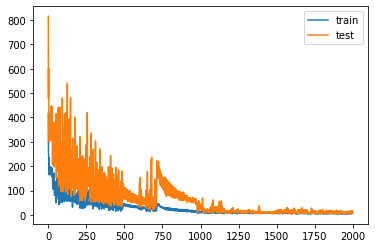

In [17]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Make predictions based on test set and get a root mean squared error 

In [18]:
from sklearn.metrics import mean_squared_error
import math

yhat = cnn_model.predict(test_X)
mse = mean_squared_error(test_y, yhat)
rmse = math.sqrt(mse)

In [19]:
rmse

20.00528017875779